In [1]:
import pandas as pd
import geopandas as gpd

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

import os

data_path = '/home/fterroso/data/'

/home/fterroso/python/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Read TWT trips

In [10]:
def read_twt_trips_enriched_fn():
    trips_df = pd.read_csv(os.path.join('data', 'trips_enriched.csv'), index_col=0, parse_dates='timestamp_o timestamp_d'.split())
    trips_df['time_duration'] = trips_df['timestamp_d'] - trips_df['timestamp_o']
    trips_df['time_duration_in_h'] = trips_df['time_duration'].apply(lambda x: round(x.seconds/3600,2))
    trips_df = trips_df[trips_df['time_duration_in_h']>0]
    trips_df['speed_km_h'] = trips_df['dist_km'] / trips_df['time_duration_in_h']
    trips_df['timestamp_o_str']= trips_df['timestamp_o'].apply(lambda x:x.strftime('%Y-%m-%d'))
    return trips_df

In [11]:
def read_and_clean_twt_trips_fn():
    df_=read_twt_trips_enriched_fn()
    clean_df_=df_[(df_['time_duration_in_h']<=12)&(df_['speed_km_h']<500)]
    print("total trips: {}, clean trips: {} ({} trips removed)".format(df_.shape[0], clean_df_.shape[0], df_.shape[0]- clean_df_.shape[0]))
    return clean_df_

In [12]:
twt_trips_df=read_and_clean_twt_trips_fn()

total trips: 342245, clean trips: 261990 (80255 trips removed)


In [13]:
twt_trips_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261990 entries, 0 to 348287
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   user_id             261990 non-null  int64              
 1   tw_id_o             261990 non-null  int64              
 2   timestamp_o         261990 non-null  datetime64[ns, UTC]
 3   CPRO_o              261990 non-null  int64              
 4   NPRO_O              261990 non-null  object             
 5   CGRUPO_o            261990 non-null  object             
 6   NGRUPO_o            261990 non-null  object             
 7   POB_GRUPO_o         261990 non-null  float64            
 8   geom_o              261990 non-null  object             
 9   tw_id_d             261990 non-null  int64              
 10  timestamp_d         261990 non-null  datetime64[ns, UTC]
 11  CPRO_d              261990 non-null  int64              
 12  NPRO_d          

In [14]:
twt_trips_df.head(2)

,user_id,tw_id_o,timestamp_o,CPRO_o,NPRO_O,CGRUPO_o,NGRUPO_o,POB_GRUPO_o,geom_o,tw_id_d,...,CGRUPO_d,NGRUPO_d,POB_GRUPO_d,geom_d,time_duration,geom,dist_km,time_duration_in_h,speed_km_h,timestamp_o_str
0,1258006388,1242014584019529728,2020-03-23 09:05:27+00:00,41,Sevilla,084S,Sevilla (SCD Number 4-A),18.048,POINT (241155.7030033822 4141397.433281829),1242190058716835842,...,025S,Alcalá del Río,12.029,POINT (238412.4162063967 4160382.205794079),0 days 11:37:16,LINESTRING (241155.7030033822 4141397.43328182...,19.18195,11.62,1.650770,2020-03-23
1,1258006388,1242190058716835842,2020-03-23 20:42:43+00:00,41,Sevilla,025S,Alcalá del Río,12.029,POINT (238412.4162063967 4160382.205794079),1242239109504151564,...,084S,Sevilla (SCD Number 4-A),18.048,POINT (241155.7030033822 4141397.433281829),0 days 03:14:55,LINESTRING (238412.4162063967 4160382.20579407...,19.18195,3.25,5.902138,2020-03-23


## Define time period of interest

In [15]:
import datetime
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d') #datetime.datetime.now()
i_date = datetime.datetime.strptime('2020-03-22', '%Y-%m-%d')

from datetime import date, timedelta

delta = e_date - i_date       # as timedelta

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

## Read MAs

In [29]:
ma_gdf = gpd.read_file(os.path.join('data', 'mov_areas_enriched.geojson'), encoding='UTF-8')

In [ ]:
ma_gdf.head()

In [ ]:
ma_ids = ma_gdf['ID_GRUPO'].unique().tolist()

## Generate OD matrices per date based on MAs

In [ ]:
def generate_od_matrix(ids_):
    od_ = pd.DataFrame(0,columns=ids_+['total'], index=ids_+['total'])
    return od_

In [ ]:
global_od_matrix = generate_od_matrix(ma_ids)

In [ ]:
global_od_matrix.tail()

In [ ]:
twt_trips_df.head()

In [ ]:
def generate_od_matrices_fn(col_o, col_d, ids_):
    global_od = generate_od_matrix(ids_)
    ods = {}
    for d in tqdm_notebook(target_days):
        trips_date_df = twt_trips_df[twt_trips_df['timestamp_o_str']==d.strftime('%Y-%m-%d')]
        date_od_matrix = generate_od_matrix(ids_)

        for origin_ma in trips_date_df[col_o].unique():
            ma_trips_df = trips_date_df[trips_date_df[col_o]==origin_ma]
            for destination_ma in ma_trips_df[col_d].unique():
                n_trips = ma_trips_df[ma_trips_df[col_d]==destination_ma].shape[0]
                date_od_matrix.loc[origin_ma,destination_ma]= n_trips

                global_od.loc[origin_ma,destination_ma] += n_trips

        date_od_matrix['total'] = date_od_matrix.sum(axis=1)
        date_od_matrix.loc['total'] = date_od_matrix.sum()
        ods[d.strftime('%Y-%m-%d')]= date_od_matrix
    
    global_od['total'] = global_od.sum(axis=1)
    global_od.loc['total'] = global_od.sum()
    return global_od, ods

In [ ]:
global_od_matrix, ods = generate_od_matrices_fn('CGRUPO_o', 'CGRUPO_d', ma_ids)

In [ ]:
for date in tqdm_notebook(ods):
    ods[date].to_csv(os.path.join('data', 'OD', 'date_TWT_OD_{}.csv'.format(date)))

In [ ]:
global_od_matrix.tail()

In [ ]:
global_od_matrix.to_csv(os.path.join('data', 'OD', 'global_TWT_OD.csv'))

## Generate OD matrices per date based on provinces

In [ ]:
prov_ids = ma_gdf['CPRO'].unique().tolist()

In [ ]:
global_od_matrix_prov, ods_prov = generate_od_matrices_fn('CPRO_o', 'CPRO_d', prov_ids)

In [ ]:
global_od_matrix_prov.tail()

In [ ]:
global_od_matrix_prov.to_csv(os.path.join('data', 'OD', 'global_TWT_OD_prov.csv'))

In [ ]:
for date in tqdm_notebook(ods_prov):
    ods_prov[date].to_csv(os.path.join('data', 'OD', 'date_TWT_OD_{}_prov.csv'.format(date)))

# Plot descriptive maps

### Read MA file

In [44]:
ma_gdf = gpd.read_file(os.path.join('data', 'mov_areas_enriched.geojson'), encoding='UTF-8')

In [45]:
ma_gdf.shape

(3214, 7)

In [46]:
ma_nocanary_gdf = ma_gdf[(~ma_gdf['ID_GRUPO'].str.contains('GC')) & (~ma_gdf['ID_GRUPO'].str.contains('TF'))]

In [47]:
ma_nocanary_gdf.shape

(3099, 7)

In [48]:
ma_nocanary_gdf = ma_nocanary_gdf.set_index('ID_GRUPO')

In [49]:
ma_nocanary_gdf.shape

(3099, 6)

In [50]:
ma_nocanary_gdf.head(3)

,Shape_Area,CPRO,NPRO,POB_GRUPO,LITERAL_GRUPO,geometry
ID_GRUPO,,,,,,
001A,8.237841e+07,3,Alicante,7.903,"Montesinos, Los y Algorfa","POLYGON ((696312.177 4215979.057, 696312.181 4..."
001B,1.452931e+08,8,Barcelona,14.529,Sant Joan de Vilatorrada y otros municipios,"POLYGON ((898992.611 4638407.292, 898992.603 4..."
001M,4.756526e+08,28,Madrid,5.149,Fuentidueña de Tajo y otros municipios,"POLYGON ((494216.778 4445259.734, 494216.385 4..."


### Read global OD matrix

In [10]:
global_od_matrix= pd.read_csv(os.path.join('data', 'OD', 'global_TWT_OD.csv'), index_col=0)

In [11]:
global_od_matrix.tail()

,001A,001B,001M,001S,001V,002A,002B,002M,002S,002V,...,40TF,57TF,58TF,43AL,44AL,45AL,53MA,79MA,80MA,total
45AL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,15,0,0,0,0,31
53MA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,23,0,27
79MA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,23,0,23,552
80MA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,36,0,87
total,18,52,19,34,15,50,94,34,6,33,...,0,0,0,79,293,15,36,589,69,261990


# MAs boundaries

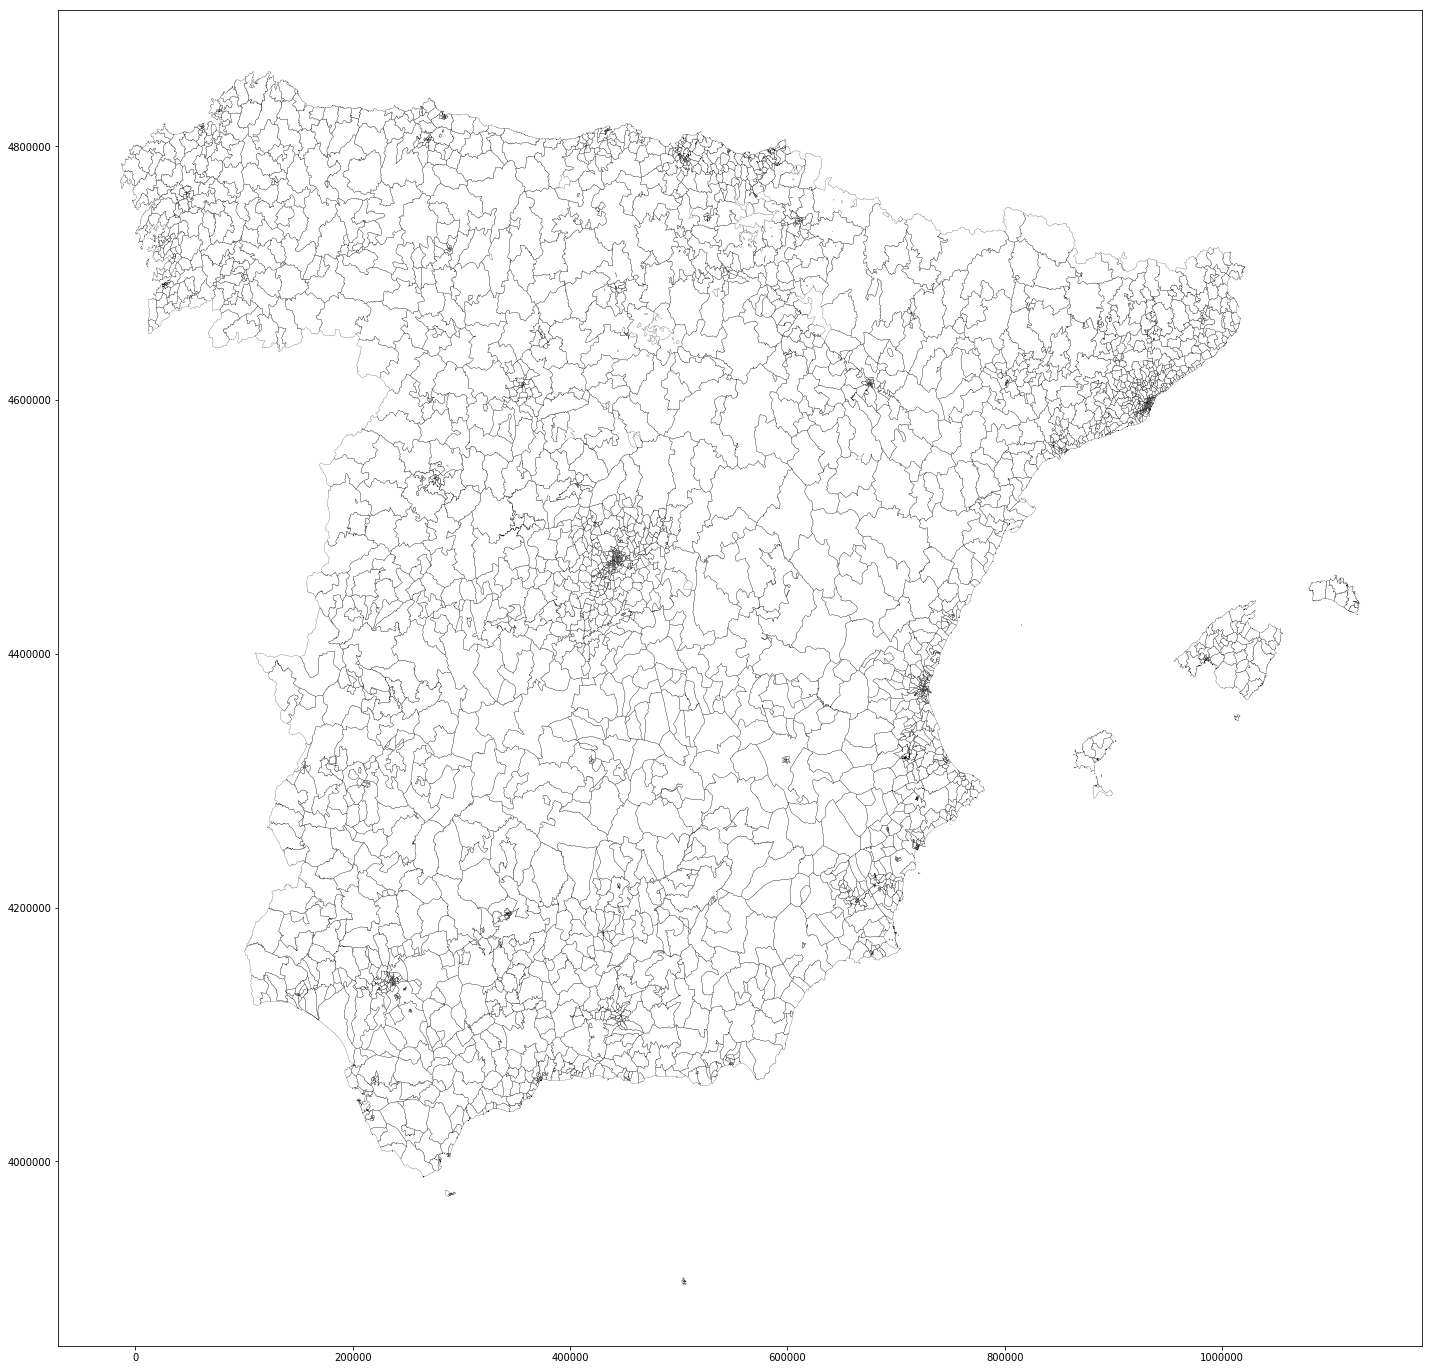

In [29]:
ma_nocanary_gdf.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.2, figsize=(20,30)); 
plt.tight_layout()
plt.savefig(os.path.join('figs', 'ma_raw_map.png'),bbox_inches='tight')

## Total outgoing trips map

In [13]:
ma_nocanary_gdf['outgoing_trips'] = global_od_matrix['total']

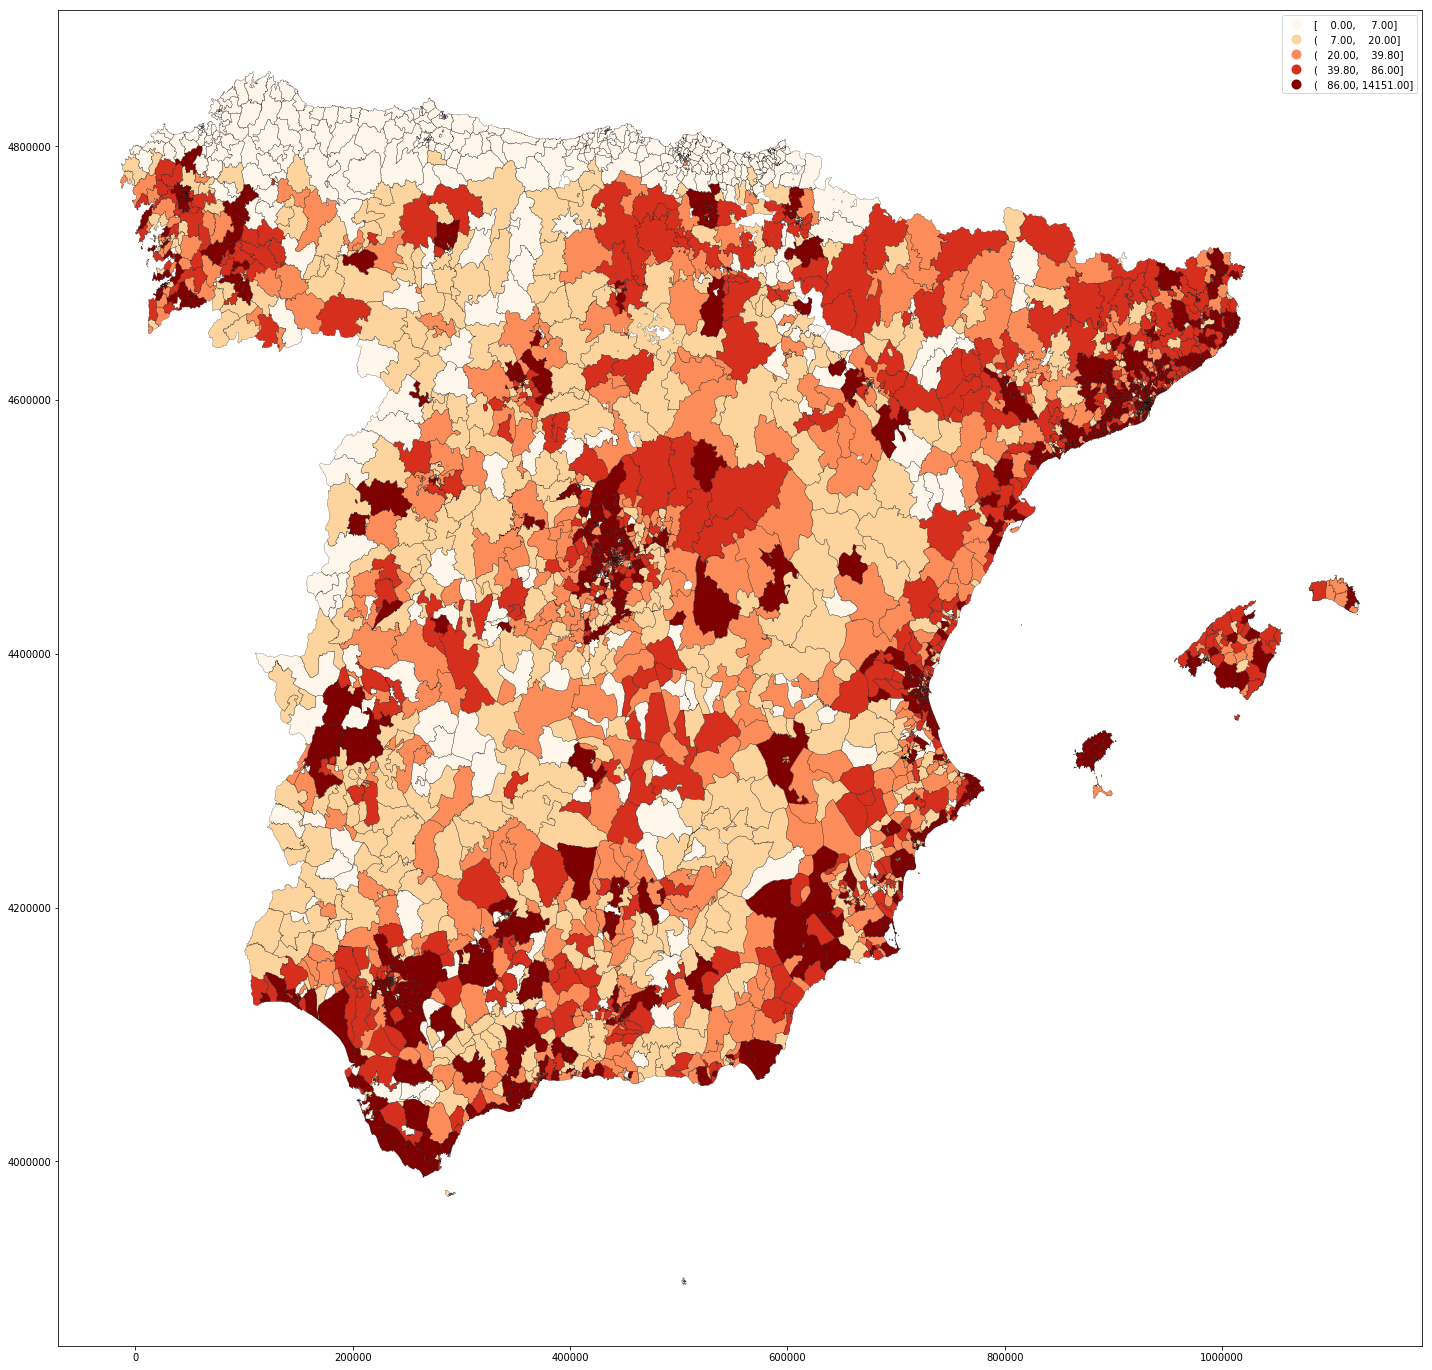

In [14]:
ax= ma_nocanary_gdf.plot(column='outgoing_trips', legend=True, figsize=(20,30),cmap='OrRd', scheme='quantiles');
ma_nocanary_gdf.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.2,ax=ax); 
#ax.legend(loc='lower right')
#plt.title('Total number of outgoing trips');
plt.tight_layout()
plt.savefig(os.path.join('figs', 'twt_outgoing_map.png'))

## Total incoming trips map

In [15]:
incoming_trips_df = global_od_matrix.loc['total'].to_frame()

In [16]:
incoming_trips_df.head()

,total
001A,18
001B,52
001M,19
001S,34
001V,15


In [17]:
ma_nocanary_gdf['incoming_trips'] = incoming_trips_df['total']

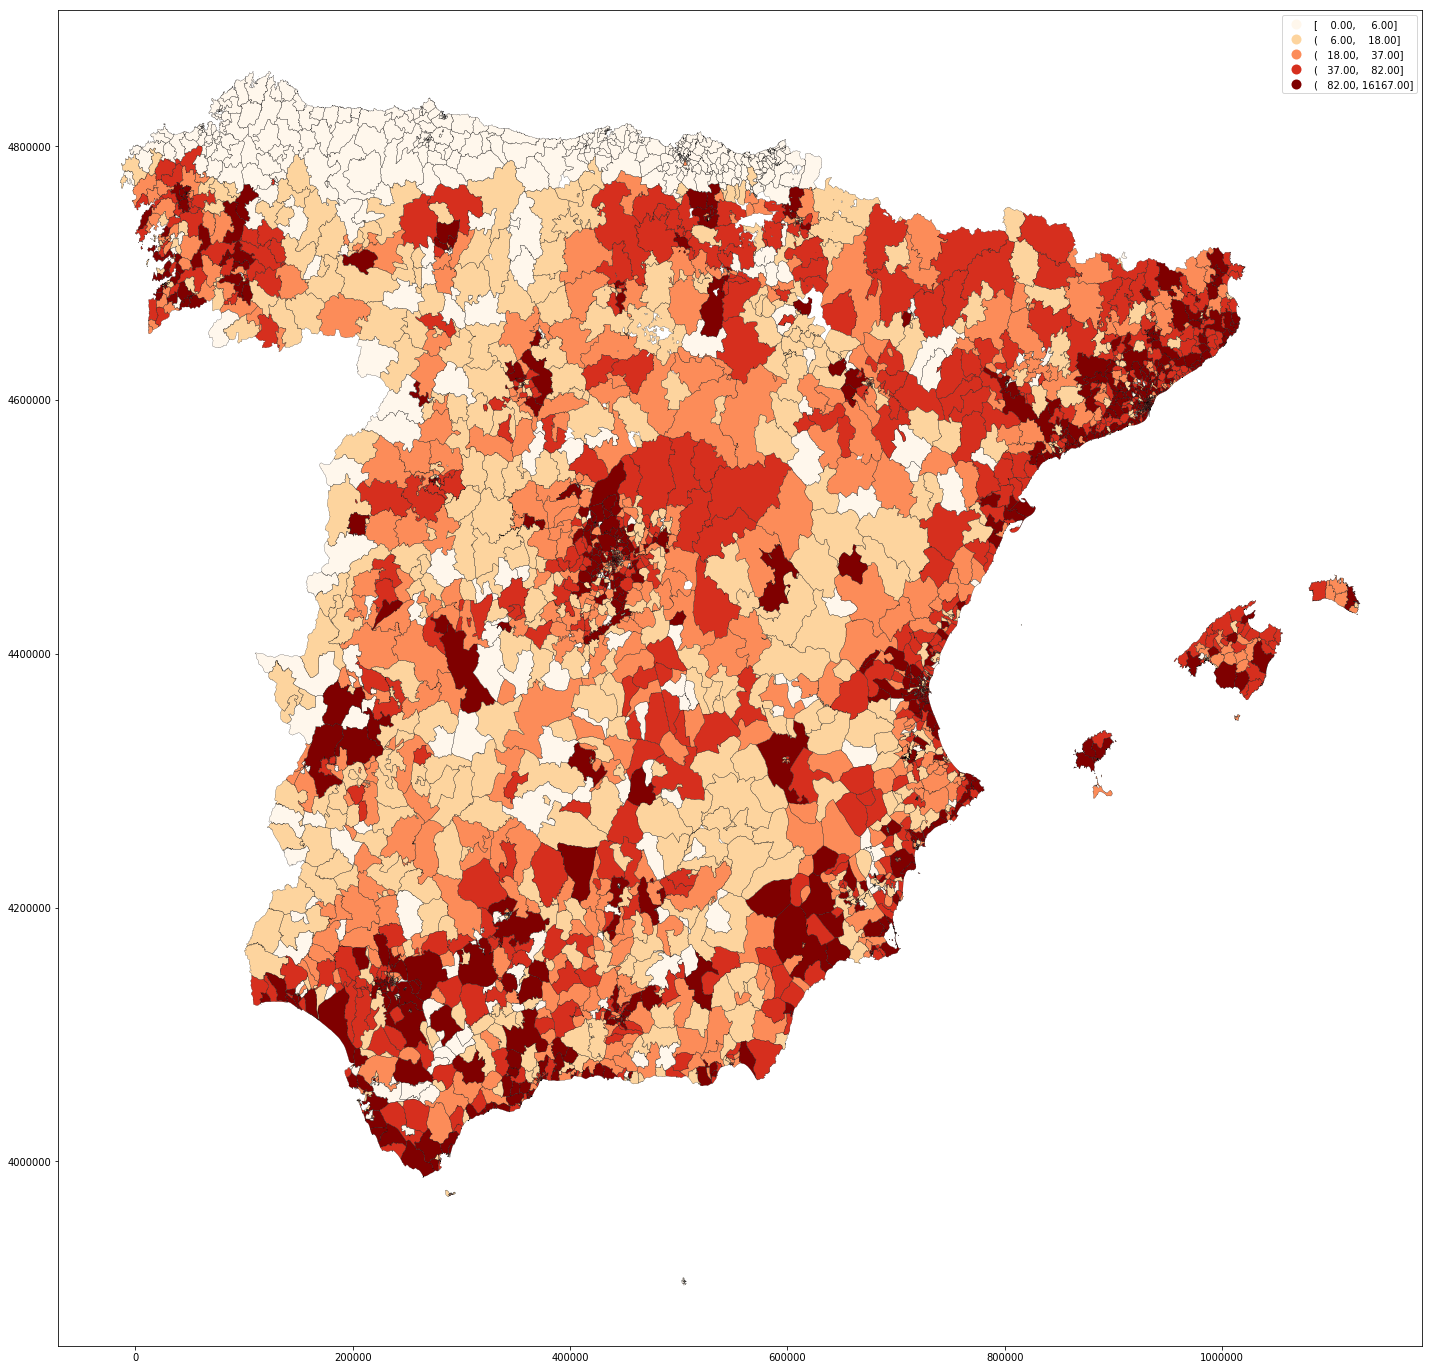

In [18]:
ax= ma_nocanary_gdf.plot(column='incoming_trips', legend=True, figsize=(20,30),cmap='OrRd', scheme='quantiles');
ma_nocanary_gdf.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.2,ax=ax); 
#plt.title('Total number of incoming trips');
plt.tight_layout()
plt.savefig(os.path.join('figs', 'twt_incoming_map.png'))

## Difference through time period

In [2]:
import datetime

In [3]:
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

In [4]:
test_od= pd.read_csv(os.path.join('data', 'OD', 'date_TWT_OD_{}.csv'.format(i_date.strftime('%Y-%m-%d'))), 
                        index_col=0)

In [5]:
ids= test_od.columns.tolist()

In [6]:
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d') #datetime.datetime.now()
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

from datetime import date, timedelta
delta = e_date - i_date       # as timedelta


In [7]:
total_diff_df = pd.DataFrame(0,index=ids, columns=range(1,delta.days+1))

In [8]:
target_days = []
for i in range(delta.days):
    next_day = i_date + timedelta(days=i)

    next_od= pd.read_csv(os.path.join('data', 'OD', 'date_TWT_OD_{}.csv'.format(next_day.strftime('%Y-%m-%d'))), 
                        index_col=0)
    
    #diff_df = next_od - curr_od
    #print(diff_df.loc['total','total'])
    
    total_diff_df[i] = next_od['total']

In [9]:
from scipy.stats import linregress

def calculate_slope_fn(row):
    x= row.index.tolist()
    y= row.values
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope

In [10]:
total_diff_df['slope']= total_diff_df.apply(lambda row:calculate_slope_fn(row), axis=1)

In [12]:
total_diff_df['slope_rank']=total_diff_df['slope'].rank(ascending=False, method='first')

In [37]:
total_diff_df.tail()

,1,2,3,4,5,6,7,8,9,10,...,74,75,76,77,78,79,80,0,slope,slope_rank
45AL,0,2,0,0,1,8,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.008401,3093.0
53MA,0,0,0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.001513,1672.0
79MA,5,4,0,6,8,0,0,2,6,0,...,11,9,2,10,11,7,0,2,0.086766,49.0
80MA,2,4,3,4,0,0,0,0,0,3,...,2,0,1,4,1,2,0,0,0.006346,943.0
total,2450,2503,554,1319,2247,4373,0,1717,2253,2052,...,4139,3676,3671,3694,4375,4738,0,2375,27.813415,1.0


In [42]:
total_diff_no_total_df= total_diff_df.drop('total')

In [43]:
total_diff_no_total_df.tail()

,1,2,3,4,5,6,7,8,9,10,...,74,75,76,77,78,79,80,0,slope,slope_rank
44AL,6,2,0,3,5,5,0,2,4,5,...,2,0,2,2,6,6,0,0,0.002371,1509.0
45AL,0,2,0,0,1,8,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.008401,3093.0
53MA,0,0,0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.001513,1672.0
79MA,5,4,0,6,8,0,0,2,6,0,...,11,9,2,10,11,7,0,2,0.086766,49.0
80MA,2,4,3,4,0,0,0,0,0,3,...,2,0,1,4,1,2,0,0,0.006346,943.0


In [44]:
total_diff_no_total_df['slope_rank'].nunique()

3214

In [45]:
import seaborn as sns

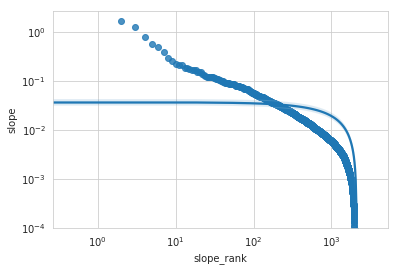

In [56]:
sns.set_style("whitegrid")
ax= sns.regplot(x=total_diff_no_total_df['slope_rank'], y=total_diff_no_total_df['slope'])
ax.set_xscale('log')
ax.set_yscale('log')

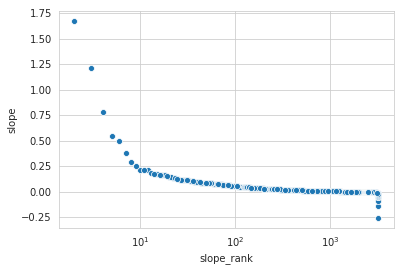

In [54]:
sns.set_style("whitegrid")
ax= sns.scatterplot(data=total_diff_no_total_df, x='slope_rank', y='slope')
ax.set_xscale('log')
#ax.set_yscale('log')

We seve the dataframe to use it in notebook 06B for comparative purposes

In [55]:
total_diff_no_total_df.to_csv(os.path.join('data', 'diff_trips_TWT.csv'))

In [51]:
ma_nocanary_gdf['diff_trips'] = total_diff_df['slope']

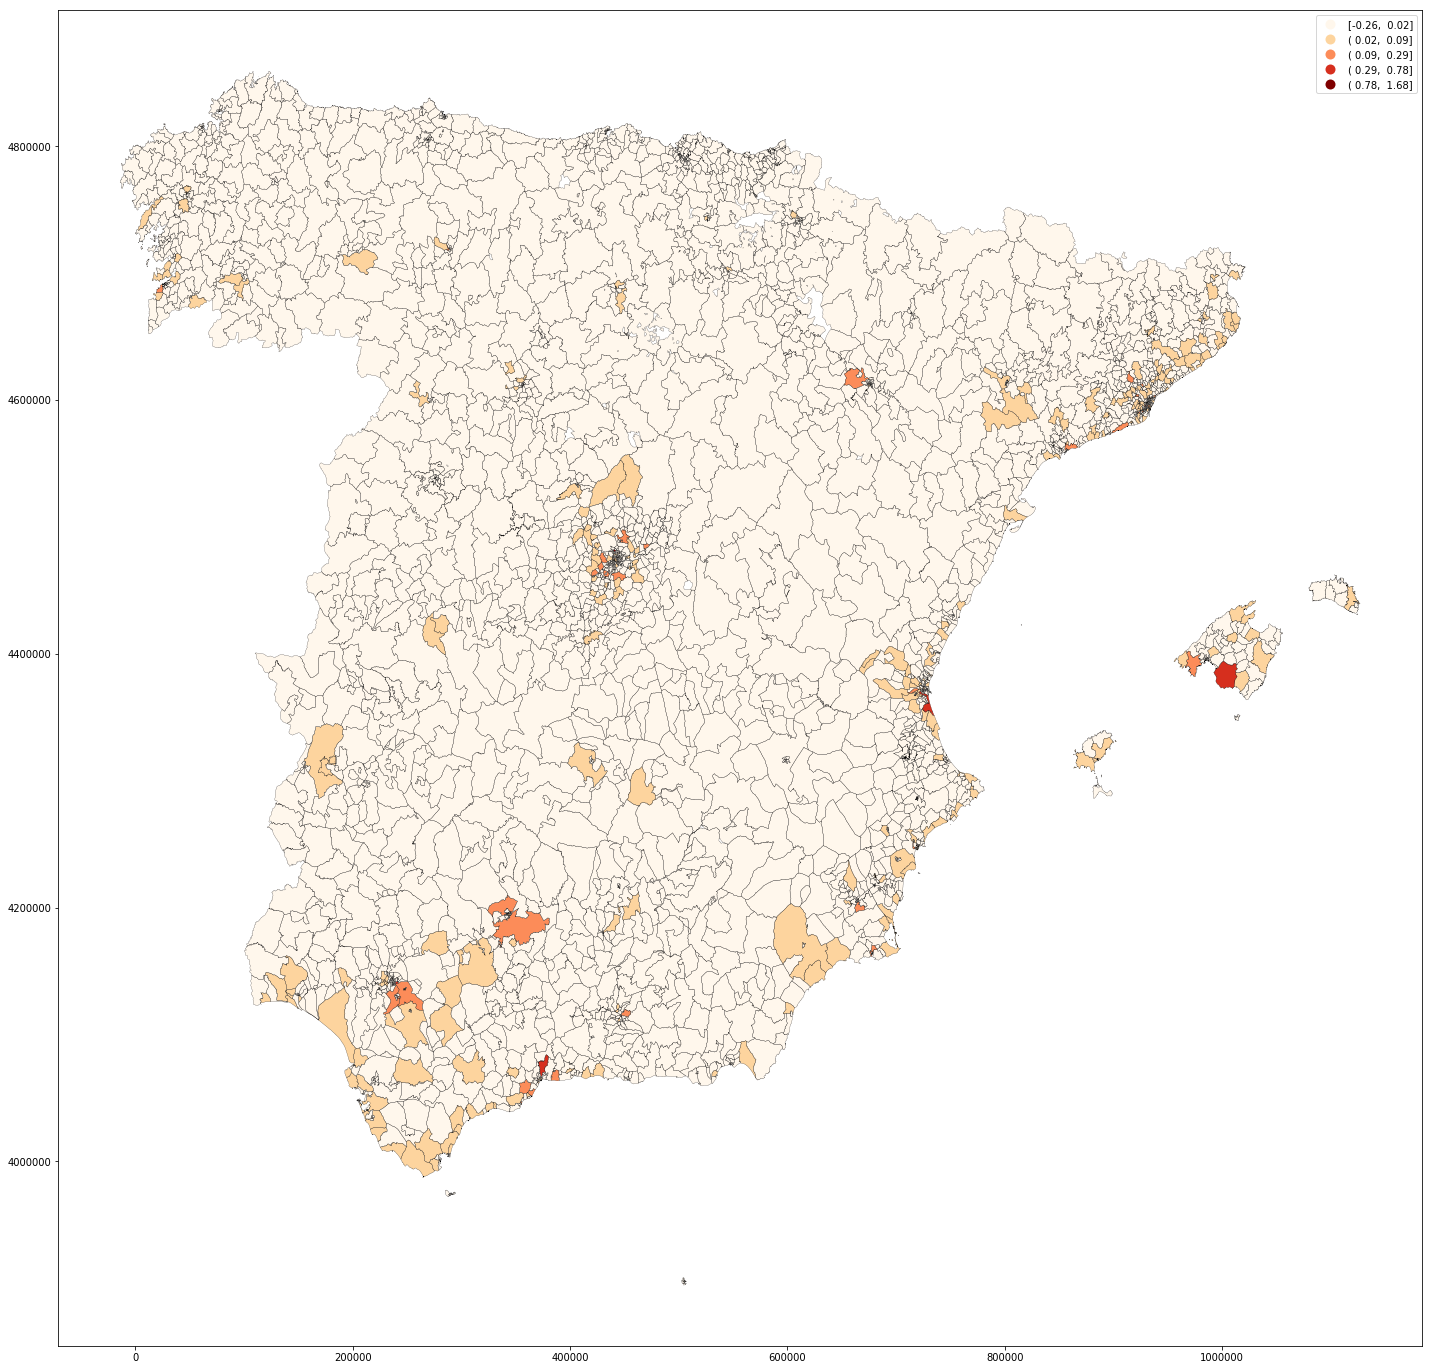

In [54]:
ax= ma_nocanary_gdf.plot(column='diff_trips', legend=True, figsize=(20,30),cmap='OrRd', scheme='FisherJenks');
ma_nocanary_gdf.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.2,ax=ax); 
#plt.title('Difference in trips');
plt.tight_layout()
plt.savefig(os.path.join('figs', 'twt_diff_map.png'))

In [53]:
print("That's all folks!")

That's all folks!
